In [1]:
# Activate environment in current folder
using Pkg
Pkg.activate(pwd())


  Activating project at `~/Desktop/School Stuff/Winter 2024/Research/2024-frequency-memory`


In [4]:
# Import packages
using Dates, Plots, DifferentialEquations, LaTeXStrings, Statistics, Measures, Peaks, DelimitedFiles, Roots, QuadGK, SpecialFunctions, Interpolations, BenchmarkTools, Waveforms

In [57]:
function integrate(f, p, u0, times; cb = nothing, transient = 0, int_method = Vern9(), dt = false)
    # Helper function to integrate a system of ode
    
    prob = ODEProblem(f, u0, (times[1], times[end]+transient), p, callback = cb)
    sol = solve(prob, int_method, dt = dt, saveat = times .+ transient)

    return sol
end

function palette_from_hex(hex_list)
    # Function that returns a Julia color palette based on a list of hex codes
    hash_list = [string("#", i) for i in hex_list]
    
    pal = []
    for i in hash_list
        push!(pal, parse(Colorant, i))
    end
    return palette(pal)
end

custom_palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])

default(
    linewidth = 2, 
    markerstrokewidth = 0,
    palette = palette_from_hex(["009afa","e36f47","3ea44d","c371d2","ac8e18", "03aaae","ed5e93","c68225","03a98d","8e971d", "03a9cc","9b7fe9","618df6","f06073","dd65b6", "6c9f33","f61067","f7aef8","72ddf7","5e239d", "80ff72","00afb9","685044","fed9b7","f07167"])
)

coup_func = sin

# Plotting formatter
cos_func(x, y) = (x, cos(y))
sawfunc(x, y) = (x, coup_func(y))
plt_mod = [(cos_func, 0, 1), (cos_func, 0, 2), 3, (cos_func, 0, 4)];


# coupling function
function coupling_atan(x)
    return atan(8*(1-x))/8 + x
end

# defining some functions to detect the phase differences
function center_phase(x; circ = 2*π)
    mod(x + circ/2, circ) - circ/2
end

function circ_distance(x1, x2; circ = 2*π)
    foo1 =  - center_phase.(x1) + center_phase.(x2)
    foo1 = mod.(foo1 .+ π, 2*π) .- π
end

function cluster_detect(points; max_clusters = 4, thresh = 0.05)
    # Function that takes in a list of complex numbers and figures out how many tight clusters there are

    # iterates over possible cycle lengths and checks if each cycle lengths is of order i
    for i in 1:max_clusters
        sections = points[1:i:end] # list of points with the given cycle as interval

        # check if distance of points from their mean is within treshhold
        mm = mean(sections) # average positions of points
        farthest = maximum(abs.(sections .- mm))    # highest distance between points and their average (a perfect cluster would have this as 0)
        if farthest < thresh
            return i    # if we detect that all the points are close enough to the mean, then we conclude that the system is in this cyclic regime
        end
    end

    return NaN # if we go through all the cycles and none present a cyclic behaviour, then we conclude that they are not entrained
end

function plot_traj(sol)
    # function to plot the trajectories for the unentrained system

    # trajectories
    plt1 = plot(sol, idxs = [(cos_func, 0, 1), (sawfunc, 0, 2)])

    # points around unit circle
    circle_points = exp.((0:0.01:2*π) * 1im)
    plt2 = plot(circle_points, color = :black, label = nothing)
    # peaks index
    peaks_theta = argmaxima(cos.(sol[2, :]))
    peaks_phi = argmaxima(cos.(sol[1, :]))
    
    # Phases
    phases_theta = mod.(sol[2, peaks_phi], 2*π)
    phases_phi = mod.(sol[1, peaks_theta], 2*π)

    # Get vector of complex numbers 
    complex_theta = exp.(phases_theta*1im)
    complex_phi = exp.(phases_phi*1im)
    scatter!(plt2, complex_phi, label = "ϕ", mc = 1, markersize = 8, alpha = 0.8)
    scatter!(plt2, complex_theta, label = "θ", mc = 2, markersize = 8, alpha = 0.8)
    

    # final plot 
    plt = plot(plt1, plt2, layout = (1, 2), aspect_ratio = 1.)

    return plt 
end


plot_traj (generic function with 1 method)

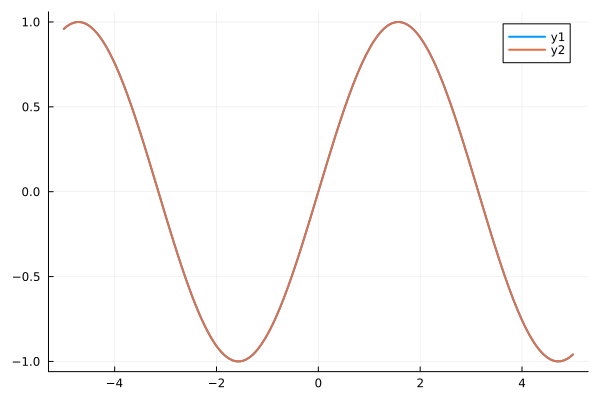

In [59]:
plot(sin)
plot!(coup_func)

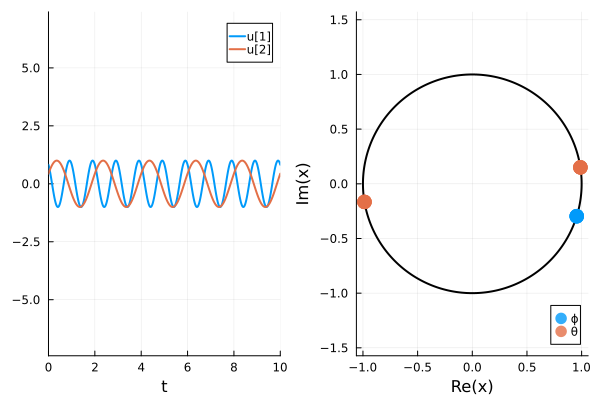

In [107]:
# Prelim test for the classical system
function f(du, u, p, t)
    du[1] = 2*π + p[2]*coup_func(u[2] - u[1])
    du[2] = 2*π*p[1]
end
times = 0:0.001:10
sol = integrate(f, [0.5, 0.05], 2*π*rand(2), times, transient = 0, int_method = Euler(), dt = 0.01)

plot_traj(sol)

In [63]:
function get_phase(p, u0; plt_tr = false)
    # function that checks if the system is entrained for a classical kuramoto entrainment system

    # times
    times = 0:0.01/p[1]:10/p[1]

    # system
    function f(du, u, p, t)
        du[1] = 2*π + p[2]*coup_func(u[2] - u[1])
        du[2] = 2*π*p[1]
    end

    # integrate system 
    sol = integrate(f, p, u0, times, transient = 100, int_method = Euler(), dt = 0.01)

    # peaks index
    peaks_theta = argmaxima(cos.(sol[2, :]))
    peaks_phi = argmaxima(cos.(sol[1, :]))
    
    # Phases
    phases_theta = mod.(sol[2, peaks_phi], 2*π)
    phases_phi = mod.(sol[1, peaks_theta], 2*π)

    # Get vector of complex numbers 
    complex_theta = exp.(phases_theta*1im)
    complex_phi = exp.(phases_phi*1im)


    if plt_tr==true
        plt = plot_traj(sol)
        savefig(plt, string("test_figs/", "test", ".png"))
        savefig(plt, string("test_figs/", now(), ".png"))
    end

    return complex_phi, complex_theta
end


function is_entrained(complex_phi, complex_theta, cycle_i, cycle_j)
    if (cycle_i == cluster_detect(complex_phi)) && (cycle_j == cluster_detect(complex_theta))
        return true
    else
        return false
    end
end
    

get_phase(
    [1.9, 1.5],
    [0.0, 0.0],
    plt_tr = true
)

    

(ComplexF64[0.27519161321792285 - 0.9613893987425268im, -0.7384842178548446 + 0.6742707616227462im, 0.6546219722694218 - 0.7559563965084841im, -0.9928529625648723 + 0.11934401839286363im, 0.9300067805321338 - 0.36754236240773047im, -0.914043008013152 - 0.40561728205571934im, 0.9845545766668345 + 0.1750779413986532im, -0.6307098586145509 - 0.7760187331800782im, 0.6872814630274319 + 0.7263912104223679im], ComplexF64[-0.4257792913759093 + 0.904827052555033im, 0.2486898873808839 + 0.9685831610731642im, 0.8090169945143934 + 0.5877852521005422im, 0.9297764857956936 - 0.36812455291845236im, -0.42577929180436314 - 0.904827052353418im])

In [64]:
# Now we look at making tongues for a wide range of periods and amplitudes

# Initialize array with stored tongue values
max_i_ratio = 2
max_j_ratio = 2
pers = LinRange(0.4, 2.2, 100)
amps = LinRange(0, 2, 100)
tongues = fill(NaN, size(amps)..., size(pers)..., max_i_ratio, max_j_ratio)


for (j, per) in (enumerate(pers))
    for (i, amp) in (enumerate(amps))
            phi, theta = get_phase([1 / per, amp], [rand() * 2 * π, 0])
            for i_cycle in 1:max_i_ratio
                for j_cycle in 1:max_j_ratio
                    if is_entrained(phi, theta, i_cycle, j_cycle)
                        #println("here ", i_cycle, j_cycle)
                        tongues[i, j, i_cycle, j_cycle] = 10*i_cycle + j_cycle
                    end
                end
            end
    end
end


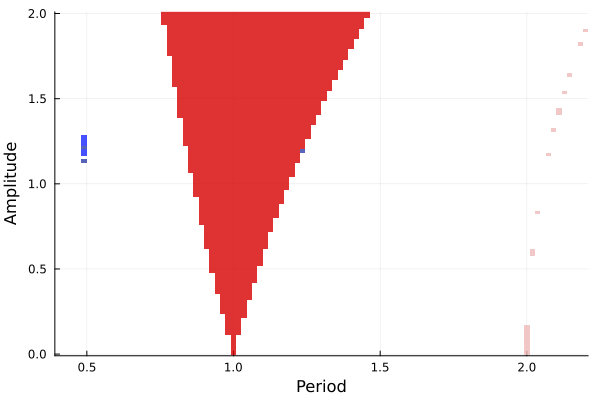

In [65]:
plt = plot(xlabel = "Period", ylabel = "Amplitude", legend = false, color = :glasbey_bw_minc_20_n256)


for i_cycle in 1:max_i_ratio
    for j_cycle in 1:max_j_ratio
        heatmap!(plt, pers, amps, tongues[:, :, i_cycle, j_cycle], color = palette(:glasbey_bw_minc_20_n256), alpha = 0.8)
    end
end

plt